In [12]:
import os
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch_geometric
import torch_geometric.data as geom_data
from torch_geometric.loader import DataLoader
import torch_geometric.nn as geom_nn
from pytorch_lightning.callbacks import ModelCheckpoint
from torch import Tensor

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
CHECKPOINT_PATH = './saved_models/GNNs/'
AVAIL_GPUS = min(1, torch.xpu.device_count())
BATCH_SIZE = 256 if AVAIL_GPUS else 64

# Setting the seed
pl.seed_everything(42)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Seed set to 42


In [14]:
#Create Checkpoint path
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

In [15]:
from ACAgraphML.Dataset import ZINC_Dataset
from ACAgraphML.Transforms import OneHotEncodeFeat

NUM_NODE_FEATS = 28  # Number of node features in ZINC dataset
oneHotTransform = OneHotEncodeFeat(NUM_NODE_FEATS)

# Custom transform to ensure float type
def ensure_float_transform(data):
    data = oneHotTransform(data)
    data.x = data.x.float()  # Ensure node features are float
    return data

train_dataset = ZINC_Dataset.SMALL_TRAIN.load(transform=ensure_float_transform)
val_dataset = ZINC_Dataset.SMALL_VAL.load(transform=ensure_float_transform)
test_dataset = ZINC_Dataset.SMALL_TEST.load(transform=ensure_float_transform)

graph_train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
graph_val_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)  # Additional loader for a larger datasets
graph_test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

print(f"Number of training graphs: {len(train_dataset)}")
print(f"Number of validation graphs: {len(val_dataset)}")
print(f"Number of test graphs: {len(test_dataset)}")

Number of training graphs: 10000
Number of validation graphs: 1000
Number of test graphs: 1000


In [16]:
batch = next(iter(graph_test_loader))
print("Batch:", batch)
print("Labels:", batch.y[:10])
print("Batch indices:", batch.batch[:40])

Batch: DataBatch(x=[5848, 28], edge_index=[2, 12572], edge_attr=[12572], y=[256], batch=[5848], ptr=[257])
Labels: tensor([ 1.9973,  0.6860,  0.7742,  0.1526, -1.3634, -0.6959, -0.5774, -1.8250,
         1.1568, -4.4950])
Batch indices: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2])


In [17]:
class GNNModel(nn.Module):
    def __init__(
        self,
        c_in,
        c_hidden,
        c_out,
        num_layers=2,
        layer_name="GCN",
        dp_rate=0.1,
        **kwargs,
    ):
        """GNNModel.

        Args:
            c_in: Dimension of input features
            c_hidden: Dimension of hidden features
            c_out: Dimension of the output features. Usually number of classes in classification
            num_layers: Number of "hidden" graph layers
            layer_name: String of the graph layer to use
            dp_rate: Dropout rate to apply throughout the network
            kwargs: Additional arguments for the graph layer (e.g. number of heads for GAT)

        """
        super().__init__()
        
        # Select the appropriate GNN layer based on layer_name
        if layer_name == "GCN":
            gnn_layer = geom_nn.GCNConv
        elif layer_name == "GraphConv":
            gnn_layer = geom_nn.GraphConv
        elif layer_name == "GAT":
            gnn_layer = geom_nn.GATConv
        elif layer_name == "SAGE":
            gnn_layer = geom_nn.SAGEConv
        else:
            gnn_layer = geom_nn.GCNConv  # Default fallback

        layers = []
        in_channels, out_channels = c_in, c_hidden
        for l_idx in range(num_layers - 1):
            layers += [
                gnn_layer(in_channels=in_channels, out_channels=out_channels, **kwargs),
                nn.ReLU(inplace=True),
                nn.Dropout(dp_rate),
            ]
            in_channels = c_hidden
        layers += [gnn_layer(in_channels=in_channels, out_channels=c_out, **kwargs)]
        self.layers = nn.ModuleList(layers)

    def forward(self, x, edge_index):
        """Forward.

        Args:
            x: Input features per node
            edge_index: List of vertex index pairs representing the edges in the graph (PyTorch geometric notation)

        """
        # Ensure x is float type
        x = x.float()
        # Ensure edge_index is long type
        edge_index = edge_index.long()
        
        for layer in self.layers:
            # For graph layers, we need to add the "edge_index" tensor as additional input
            # All PyTorch Geometric graph layer inherit the class "MessagePassing", hence
            # we can simply check the class type.
            if isinstance(layer, geom_nn.MessagePassing):
                x = layer(x, edge_index)
            else:
                x = layer(x)
        return x


In [18]:
class MLPModel(nn.Module):
    def __init__(self, c_in, c_hidden, c_out, num_layers=2, dp_rate=0.1):
        """MLPModel.

        Args:
            c_in: Dimension of input features
            c_hidden: Dimension of hidden features
            c_out: Dimension of the output features. Usually number of classes in classification
            num_layers: Number of hidden layers
            dp_rate: Dropout rate to apply throughout the network

        """
        super().__init__()
        layers = []
        in_channels, out_channels = c_in, c_hidden
        for l_idx in range(num_layers - 1):
            layers += [nn.Linear(in_channels, out_channels), nn.ReLU(inplace=True), nn.Dropout(dp_rate)]
            in_channels = c_hidden
        layers += [nn.Linear(in_channels, c_out)]
        self.layers = nn.Sequential(*layers)

    def forward(self, x, *args, **kwargs):
        """Forward.

        Args:
            x: Input features per node

        """
        return self.layers(x)

In [19]:
class GraphGNNModel(nn.Module):
    def __init__(self, c_in, c_hidden, c_out, dp_rate_linear=0.5, **kwargs):
        """GraphGNNModel.

        Args:
            c_in: Dimension of input features
            c_hidden: Dimension of hidden features
            c_out: Dimension of output features (usually number of classes)
            dp_rate_linear: Dropout rate before the linear layer (usually much higher than inside the GNN)
            kwargs: Additional arguments for the GNNModel object

        """
        super().__init__()
        self.GNN = GNNModel(c_in=c_in, c_hidden=c_hidden, c_out=c_hidden, **kwargs)  # Not our prediction output yet!
        self.head = nn.Sequential(nn.Dropout(dp_rate_linear), nn.Linear(c_hidden, c_out))

    def forward(self, x, edge_index, batch_idx):
        """Forward.

        Args:
            x: Input features per node
            edge_index: List of vertex index pairs representing the edges in the graph (PyTorch geometric notation)
            batch_idx: Index of batch element for each node

        """
        x = self.embeddings(x, edge_index, batch_idx)
        x = self.head(x)
        return x
    
    def embeddings(self, x, edge_index, batch_idx):
        """Get embeddings.

        Args:
            x: Input features per node
            edge_index: List of vertex index pairs representing the edges in the graph (PyTorch geometric notation)
            batch_idx: Index of batch element for each node

        Returns:
            Embeddings of the nodes after GNN layers but before the head layer.

        """
        x = self.GNN(x, edge_index)
        x = geom_nn.global_mean_pool(x, batch_idx)
        return x

In [20]:
from typing import Literal
class GraphLevelGNN(pl.LightningModule):
    def __init__(self, loss: Literal['mse', 'mae'] = 'mae', **model_kwargs):
        super().__init__()
        # Saving hyperparameters
        self.save_hyperparameters()

        self.model = GraphGNNModel(**model_kwargs)
        if loss == 'mae':
            self.loss_module = nn.L1Loss()
        elif loss == 'mse':
            self.loss_module = nn.MSELoss()
        else:
            raise ValueError(f"Unsupported loss type: {loss}")

    def forward(self, data, mode="train"):
        x, edge_index, batch_idx = data.x, data.edge_index, data.batch
        
        # Ensure correct data types
        x = x.float()
        edge_index = edge_index.long()
        batch_idx = batch_idx.long()
        
        x = self.model(x, edge_index, batch_idx)
        x = x.squeeze(dim=-1)

        if self.hparams.c_out == 1:
            preds = (x > 0).float()
            data.y = data.y.float()
        else:
            preds = x.argmax(dim=-1)
        loss = self.loss_module(x, data.y)
        return x, loss

    def configure_optimizers(self):
        # High lr because of small dataset and small model
        optimizer = optim.AdamW(self.parameters(), lr=1e-2, weight_decay=0.0)
        return optimizer

    def training_step(self, batch, batch_idx):
        loss = self.forward(batch, mode="train")[1]
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        y, loss = self.forward(batch, mode="val")
        self.log("val_loss", loss)
        mae = nn.L1Loss()(y, batch.y)
        self.log("val_mae", mae)
        return loss, mae

    def test_step(self, batch, batch_idx):
        y, loss = self.forward(batch, mode="test")
        # self.log("test_loss", loss)
        mae = nn.L1Loss()(y, batch.y)   
        # self.log("test_mae", mae)

In [21]:
def train_graph_classifier(model_name, maxEpochs = 100, **model_kwargs):
    pl.seed_everything(42)

    # Create a PyTorch Lightning trainer with the generation callback
    root_dir = os.path.join(CHECKPOINT_PATH, "GraphLevel" + model_name + "_hidden_" + str(model_kwargs.get("c_hidden", 2)) + "_loss_" + model_kwargs.get("loss", "mae")+"_num_layers_" + str(model_kwargs.get("num_layers", 2))+"_layer_" + model_kwargs.get("layer_name", "GraphConv") + "_dp_linear_" + str(model_kwargs.get("dp_rate_linear", 0.5)) + "_dp_" + str(model_kwargs.get("dp_rate", 0.0)))
    os.makedirs(root_dir, exist_ok=True)
    trainer = pl.Trainer(
        default_root_dir=root_dir,
        callbacks=[ModelCheckpoint(save_weights_only=True, mode="min", monitor="val_loss")],
        accelerator="cpu",
        devices=AVAIL_GPUS,
        max_epochs=maxEpochs,
        enable_progress_bar=True,
    )
    trainer.logger._default_hp_metric = None

    pl.seed_everything(42)
    model = GraphLevelGNN(
        c_in=NUM_NODE_FEATS,
        c_out=1,
        **model_kwargs,
    )
    trainer.fit(model, graph_train_loader, graph_val_loader)
    model = GraphLevelGNN.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    # Test best model on validation and test set
    train_result = trainer.test(model, dataloaders=graph_train_loader, verbose=False)
    val_result = trainer.test(model, dataloaders=graph_val_loader, verbose=False)
    result = {"val": val_result[0]["test_loss"], "train": train_result[0]["test_loss"]}
    return model, result

In [ ]:
model, result = train_graph_classifier(
    model_name="GraphConv_0", c_hidden=100, layer_name="SAGE", num_layers=2, dp_rate_linear=0.5, dp_rate=0.0, maxEpochs=100, loss='mae'
)

Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Seed set to 42

  | Name        | Type          | Params | Mode 
------------------------------------------------------
0 | model       | GraphGNNModel | 25.9 K | train
1 | loss_module | L1Loss        | 0      | train
------------------------------------------------------
25.9 K    Trainable params
0         Non-trainable params
25.9 K    Total params
0.104     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
model = GraphLevelGNN.load_from_checkpoint(
    os.path.join(CHECKPOINT_PATH, "GraphLevelGraphConv_0", "lightning_logs", "version_10", "checkpoints", "epoch=56-step=2280.ckpt"),
    hparams_file=os.path.join(CHECKPOINT_PATH, "GraphLevelGraphConv_0", "lightning_logs", "version_10", "hparams.yaml")
)
# PyTorch Lightning's LightningModule does not have a .summary() method.
# If you want to print the model architecture, use print(model) instead.
print(model)

GraphLevelGNN(
  (model): GraphGNNModel(
    (GNN): GNNModel(
      (layers): ModuleList(
        (0): GraphConv(21, 256)
        (1): ReLU(inplace=True)
        (2): Dropout(p=0.0, inplace=False)
        (3): GraphConv(256, 256)
        (4): ReLU(inplace=True)
        (5): Dropout(p=0.0, inplace=False)
        (6): GraphConv(256, 256)
      )
    )
    (head): Sequential(
      (0): Dropout(p=0.5, inplace=False)
      (1): Linear(in_features=256, out_features=1, bias=True)
    )
  )
  (loss_module): MSELoss()
)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [ ]:
#Compute and store the validation embeddings
@torch.no_grad()
def compute_embeddings(model, data_loader):
    embeddings = []
    for batch in data_loader:
        x, edge_index, batch_idx = batch.x, batch.edge_index, batch.batch
        x = model.model.embeddings(x, edge_index, batch_idx)
        embeddings.append(x)
    return torch.cat(embeddings, dim=0)
embeddings = compute_embeddings(model, graph_val_loader)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.002s...
[t-SNE] Computed neighbors for 1000 samples in 0.024s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.139738
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.720203
[t-SNE] KL divergence after 1000 iterations: 0.421139


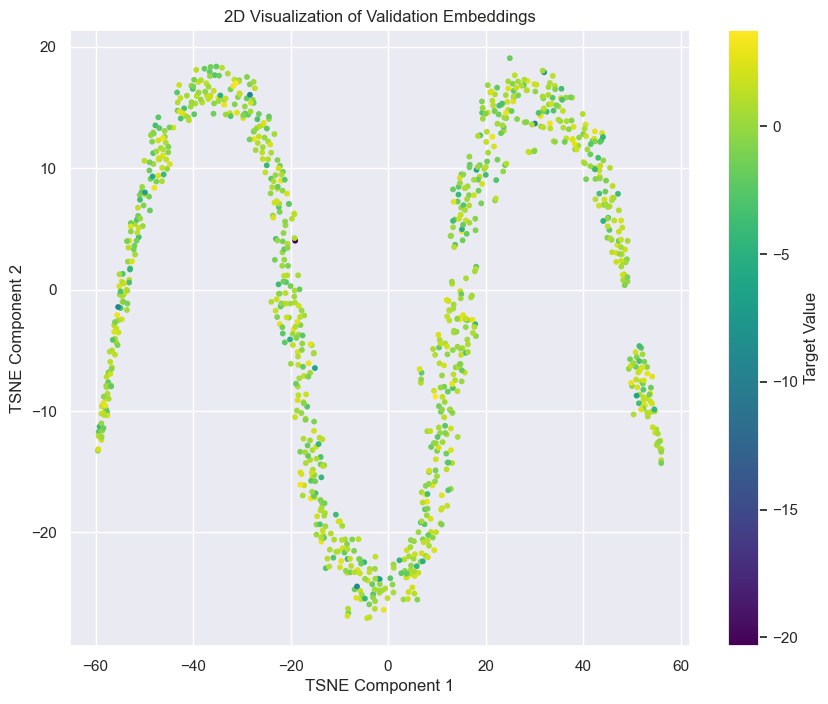

In [ ]:
#Tsne on the validation embeddings
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42, verbose=1)
val_embeddings_2d = tsne.fit_transform(embeddings.cpu().numpy())
#Plot the 2D embeddings
plt.figure(figsize=(10, 8))
plt.scatter(val_embeddings_2d[:, 0], val_embeddings_2d[:, 1], c=val_dataset.y.cpu().numpy(), cmap='viridis', s=10)
plt.colorbar(label='Target Value')
plt.title('2D Visualization of Validation Embeddings')
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.show()

In [ ]:
#Compute validation predictions
@torch.no_grad()
def compute_predictions(model, data_loader):
    predictions = []
    for batch in data_loader:
        x, edge_index, batch_idx = batch.x, batch.edge_index, batch.batch
        preds = model.model(x, edge_index, batch_idx)
        predictions.append(preds)
    return torch.cat(predictions, dim=0)

predictions_train = compute_predictions(model, graph_train_loader)
predictions_val = compute_predictions(model, graph_val_loader)
predictions_train.shape, predictions_val.shape

(torch.Size([10000, 1]), torch.Size([1000, 1]))

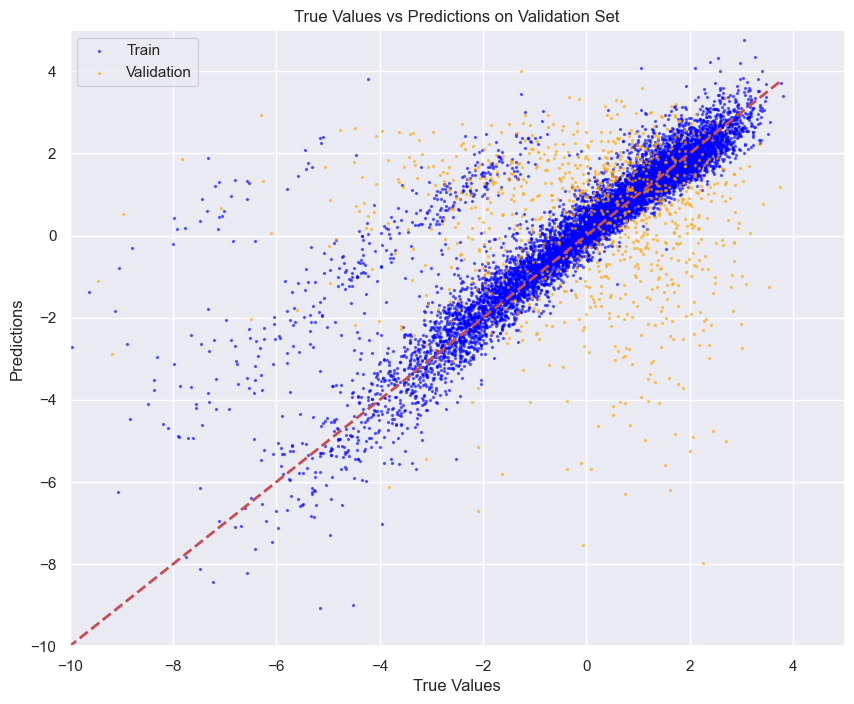

In [ ]:
#Plot target vs prediction
plt.figure(figsize=(10, 8))
plt.scatter(train_dataset.y.cpu().numpy(), predictions_train.cpu().numpy(), alpha=0.5, color='blue', s=2, label='Train')
plt.scatter(val_dataset.y.cpu().numpy(), predictions_val.cpu().numpy(), alpha=0.5, color='orange', s=2, label='Validation')
plt.plot([val_dataset.y.min(), val_dataset.y.max()], [val_dataset.y.min(), val_dataset.y.max()], 'r--', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True Values vs Predictions on Validation Set')
plt.legend()
plt.xlim(-10, 5)
plt.ylim(-10, 5)
plt.show()